# Un signal peut en cacher un autre...
## Déconvolution de spectres UV-Vis pour le stockage de l'Energie  avec des Batteries Redox Flow au Vanadium

Les batteries *Redox Flow* au Vanadium permettent de stocker l'énergie sous frome chimique et de la restituer à la demande. Cette technologie est envisagée pour stocker l'énergie produite par les sources d'énergies renouvellables intermittantes (solaire, éolien...).

Une batterie Redox Flow au Vanadium est schématisée dans l'image ci-dessous à gauche.

<img src="im1.png"/>

La batterie opère avec des solutions acides de Vanadium (dissous) à différents degrés d'oxydation (II, III, IV et V). Les solutions présentent des couleurs différentes en fonction de leurs teneurs en chacun des degrés d'oxydation (voir image ci-dessus à droite).

Lorsqu'on étudie le fonctionnement d'une telle batterie, on peut alors utiliser la spectroscopie UV-Vis pour déterminer la composition des solutions pour un état de charge (*State of Charge*) donné.

Une complication, assez commune, est que le Vanadium peut exister simultanément sous différentes formes, i.e. à différents degrés d'oxydation, et donc le spectre UV-Vis résultant est composé de la superposition des spectres de chaque forme de Vanadium. 

### Objectif du projet:
A partir d'un spectre UV-Vis d'une solution de batterie Redox Flow Vanadium, remonter à la compostion en V(II), V(III), V(IV) et V(V). 

### Méthode : Traitement du signal du spectre UV-Vis fourni (data_uv.dat)
<img src="im_uv.png"/>

+ soustraction de la ligne de base (script fourni)
+ *déconvolution* du signal, en faisant l'hypothèse que le signal est la somme de plusieurs gaussiennes, puis ajustement par les moindres carrés (curve_fit) pour trouver la position, l'amplitude et la largeur de chaque gaussienne
+ utilisation des calibrations (fournies)


## Données

### Spectres UV-Vis et Calibrations (issus de la thèse de El Hage 2020 [1])

#### Spectres UV-Vis des différentes formes du Vanadium
<img src="im2.png"/>

#### Spectres UV-Vis du Vanadium II à différentes concentrations
<img src="im5.png"/>

#### Spectres UV-Vis du Vanadium III à différentes concentrations
<img src="im3.png"/>

#### Spectres UV-Vis du Vanadium IV à différentes concentrations
<img src="im4.png"/>


**[1] R. El Hage, Etude et optimisation d'une batterie à circulation tout vanadium, 2020, Thèse de doctorat, Université Paul Sabatier-Toulouse III.**

In [1]:
### Script pour détermination de la ligne de base

from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):  
        # y : signal
        # p : ALS parameter, typically in range 0.01 - 0.001
        # lam : ALS parameter, typically in range 1e+07
        # return = baseline
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        w = ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z

In [8]:
# Commencer ici...

# Solution (possible)

Text(0, 0.5, 'Absorbance')

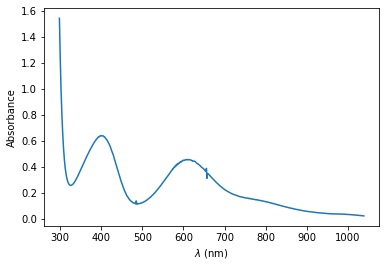

In [3]:
from pylab import *
from scipy.optimize import curve_fit

x, signal = genfromtxt('data_uv.dat',unpack= True)

figure()
plot(x,signal)
xlabel('$\lambda$ (nm)')
ylabel('Absorbance')

In [4]:
def _3gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(1/(sigma1*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
                amp3*(1/(sigma3*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

def baseline_als(y, lam, p, niter=10):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        w = ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z

Text(0, 0.5, 'Absorbance')

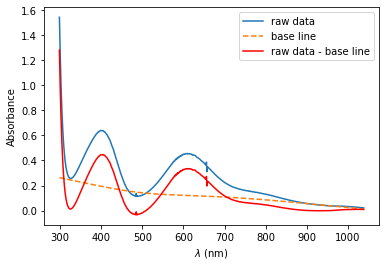

In [5]:
p = 0.01
lam = 1e+07
baseline = baseline_als(signal, lam, p, niter=10)
signal_ = signal-baseline

figure()
plot(x,signal,label = 'raw data')
plot(x,baseline,'--',label='base line')
plot(x,signal_,'r',label = 'raw data - base line')
legend()
xlabel('$\lambda$ (nm)')
ylabel('Absorbance')

Gaussian amplitudes= 0.4438916889251172 0.31844032137529515 0.0749527007813248
Gaussian centers= 397.5970881560433 609.6033226730376 717.8404604031517


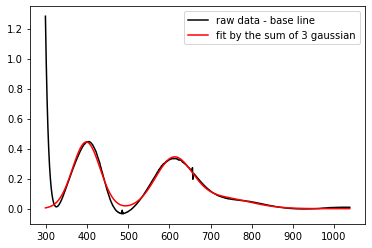

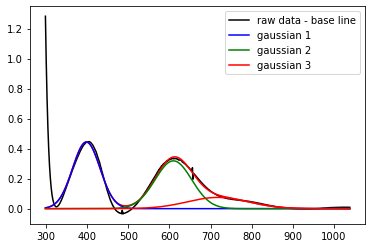

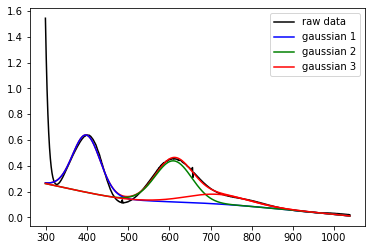

In [6]:
popt, pcov = curve_fit(_3gaussian, x, signal_, p0=[1., 400., 10., 1., 600., 10.,1.,700.,10.])

amp1 = popt[0]
cen1 = popt[1]
sigma1 = popt[2]

amp2 = popt[3]
cen2 = popt[4]
sigma2 = popt[5]

amp3 = popt[6]
cen3 = popt[7]
sigma3 = popt[8]

G1 = amp1*(1/(sigma1*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))
G2 = amp2*(1/(sigma2*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))
G3 = amp3*(1/(sigma3*(sqrt(2*pi))))*(exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

figure()
plot(x,signal_,'k',label='raw data - base line')
plot(x,_3gaussian(x, *popt),'r', label = 'fit by the sum of 3 gaussian')
legend()


figure()
plot(x,signal_,'k',label='raw data - base line')
plot(x,_3gaussian(x, *popt),'r')
plot(x,G1,'b',label = 'gaussian 1')
plot(x,G2,'g',label = 'gaussian 2')
plot(x,G3,'r',label = 'gaussian 3')
legend()
print ('Gaussian amplitudes=',max(G1), max(G2), max(G3))
print ('Gaussian centers=',cen1, cen2, cen3)



figure()
plot(x,signal_+baseline,'k',label='raw data')
plot(x,_3gaussian(x, *popt)+baseline,'r')
plot(x,G1+baseline,'b',label = 'gaussian 1')
plot(x,G2+baseline,'g',label = 'gaussian 2')
plot(x,G3+baseline,'r',label = 'gaussian 3')
legend()

In [7]:
# d'apres calcibration du V(III) et du V(IV) :

index = argmax(G1)
A_III = max(G1) + baseline[index]
print('concentration de V(III)=', A_III/(2.25/0.2))

A_IV = max(G3)
print('concentration de V(IV)=', A_IV/(3/0.15))

concentration de V(III)= 0.056772233513970045
concentration de V(IV)= 0.00374763503906624
